# Plot wet snow time series along with SNOTEL data

Last updated September 11, 2023

This notebook plots the wet snow time series of a site, and brings in some SNOTEL data for comparison.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow
from spicy_snow.retrieval import retrieval_from_parameters

## Choose a site

In [2]:
files = sorted(glob('spicy_s1_stacks/*extended.nc'))

f = files[0]
start_year = 2020

ds_name = f.split('stacks/')[-1].split('.')[0]
print(datetime.now(), f' -- starting {ds_name}')

# Open dataset 
ds_ = xr.open_dataset(f).load()
dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
closest_ts_idx = np.where(td == td.min())[0][0]
closest_ts = dataset.time[closest_ts_idx]

a = 2.5
b = 0.2
c = 0.55

ds = retrieval_from_parameters(dataset,A=a,B=b,C=c,wet_SI_thresh=0,freezing_snow_thresh=1,wet_snow_thresh=-2).rio.set_crs('EPSG:4326')

2023-10-09 10:20:48.112708  -- starting Banner_2021-03-15_extended


## Check out the wet snow time series

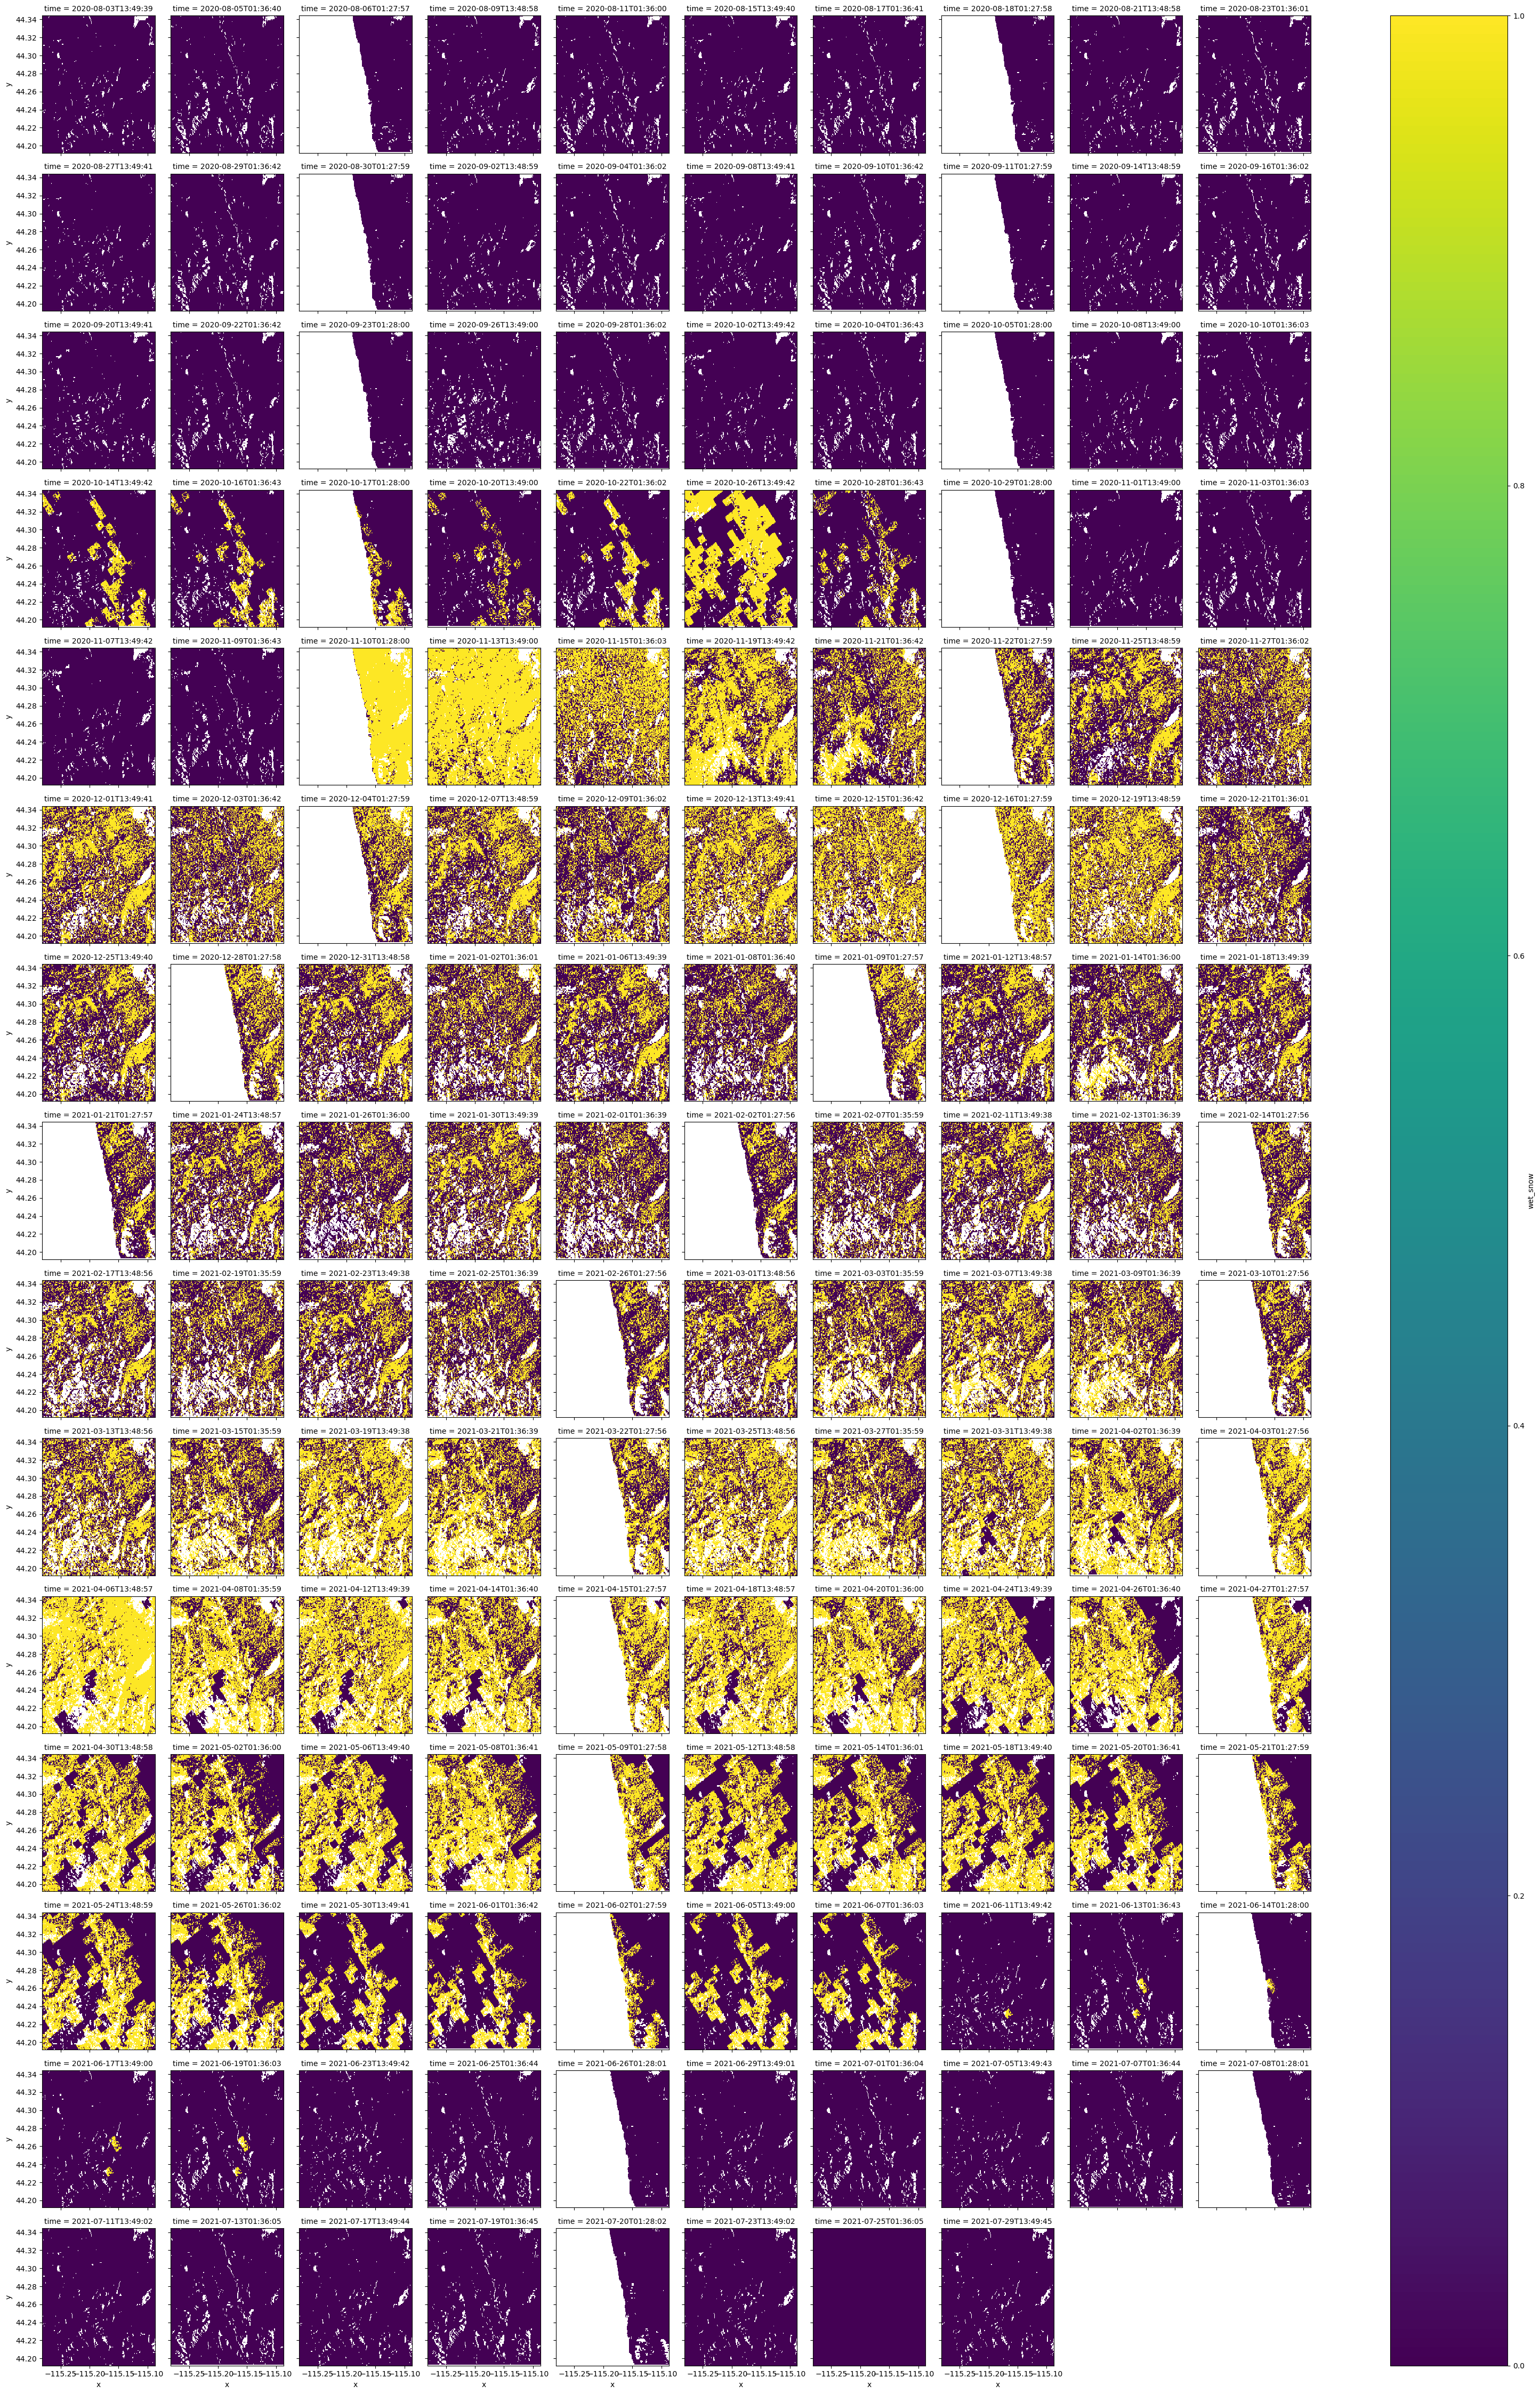

In [3]:
ds['wet_snow'].plot(col='time',col_wrap=10)
#ds['wet_flag'].plot(col='time',col_wrap=10)
#ds['alt_wet_flag'].plot(col='time',col_wrap=10)
#ds['freeze_flag'].plot(col='time',col_wrap=10)
#ds['perma_wet'].plot(col='time',col_wrap=10)
#ds['snow_index'].plot(col='time',col_wrap=10)

## Fill partial scenes and clip to lidar area

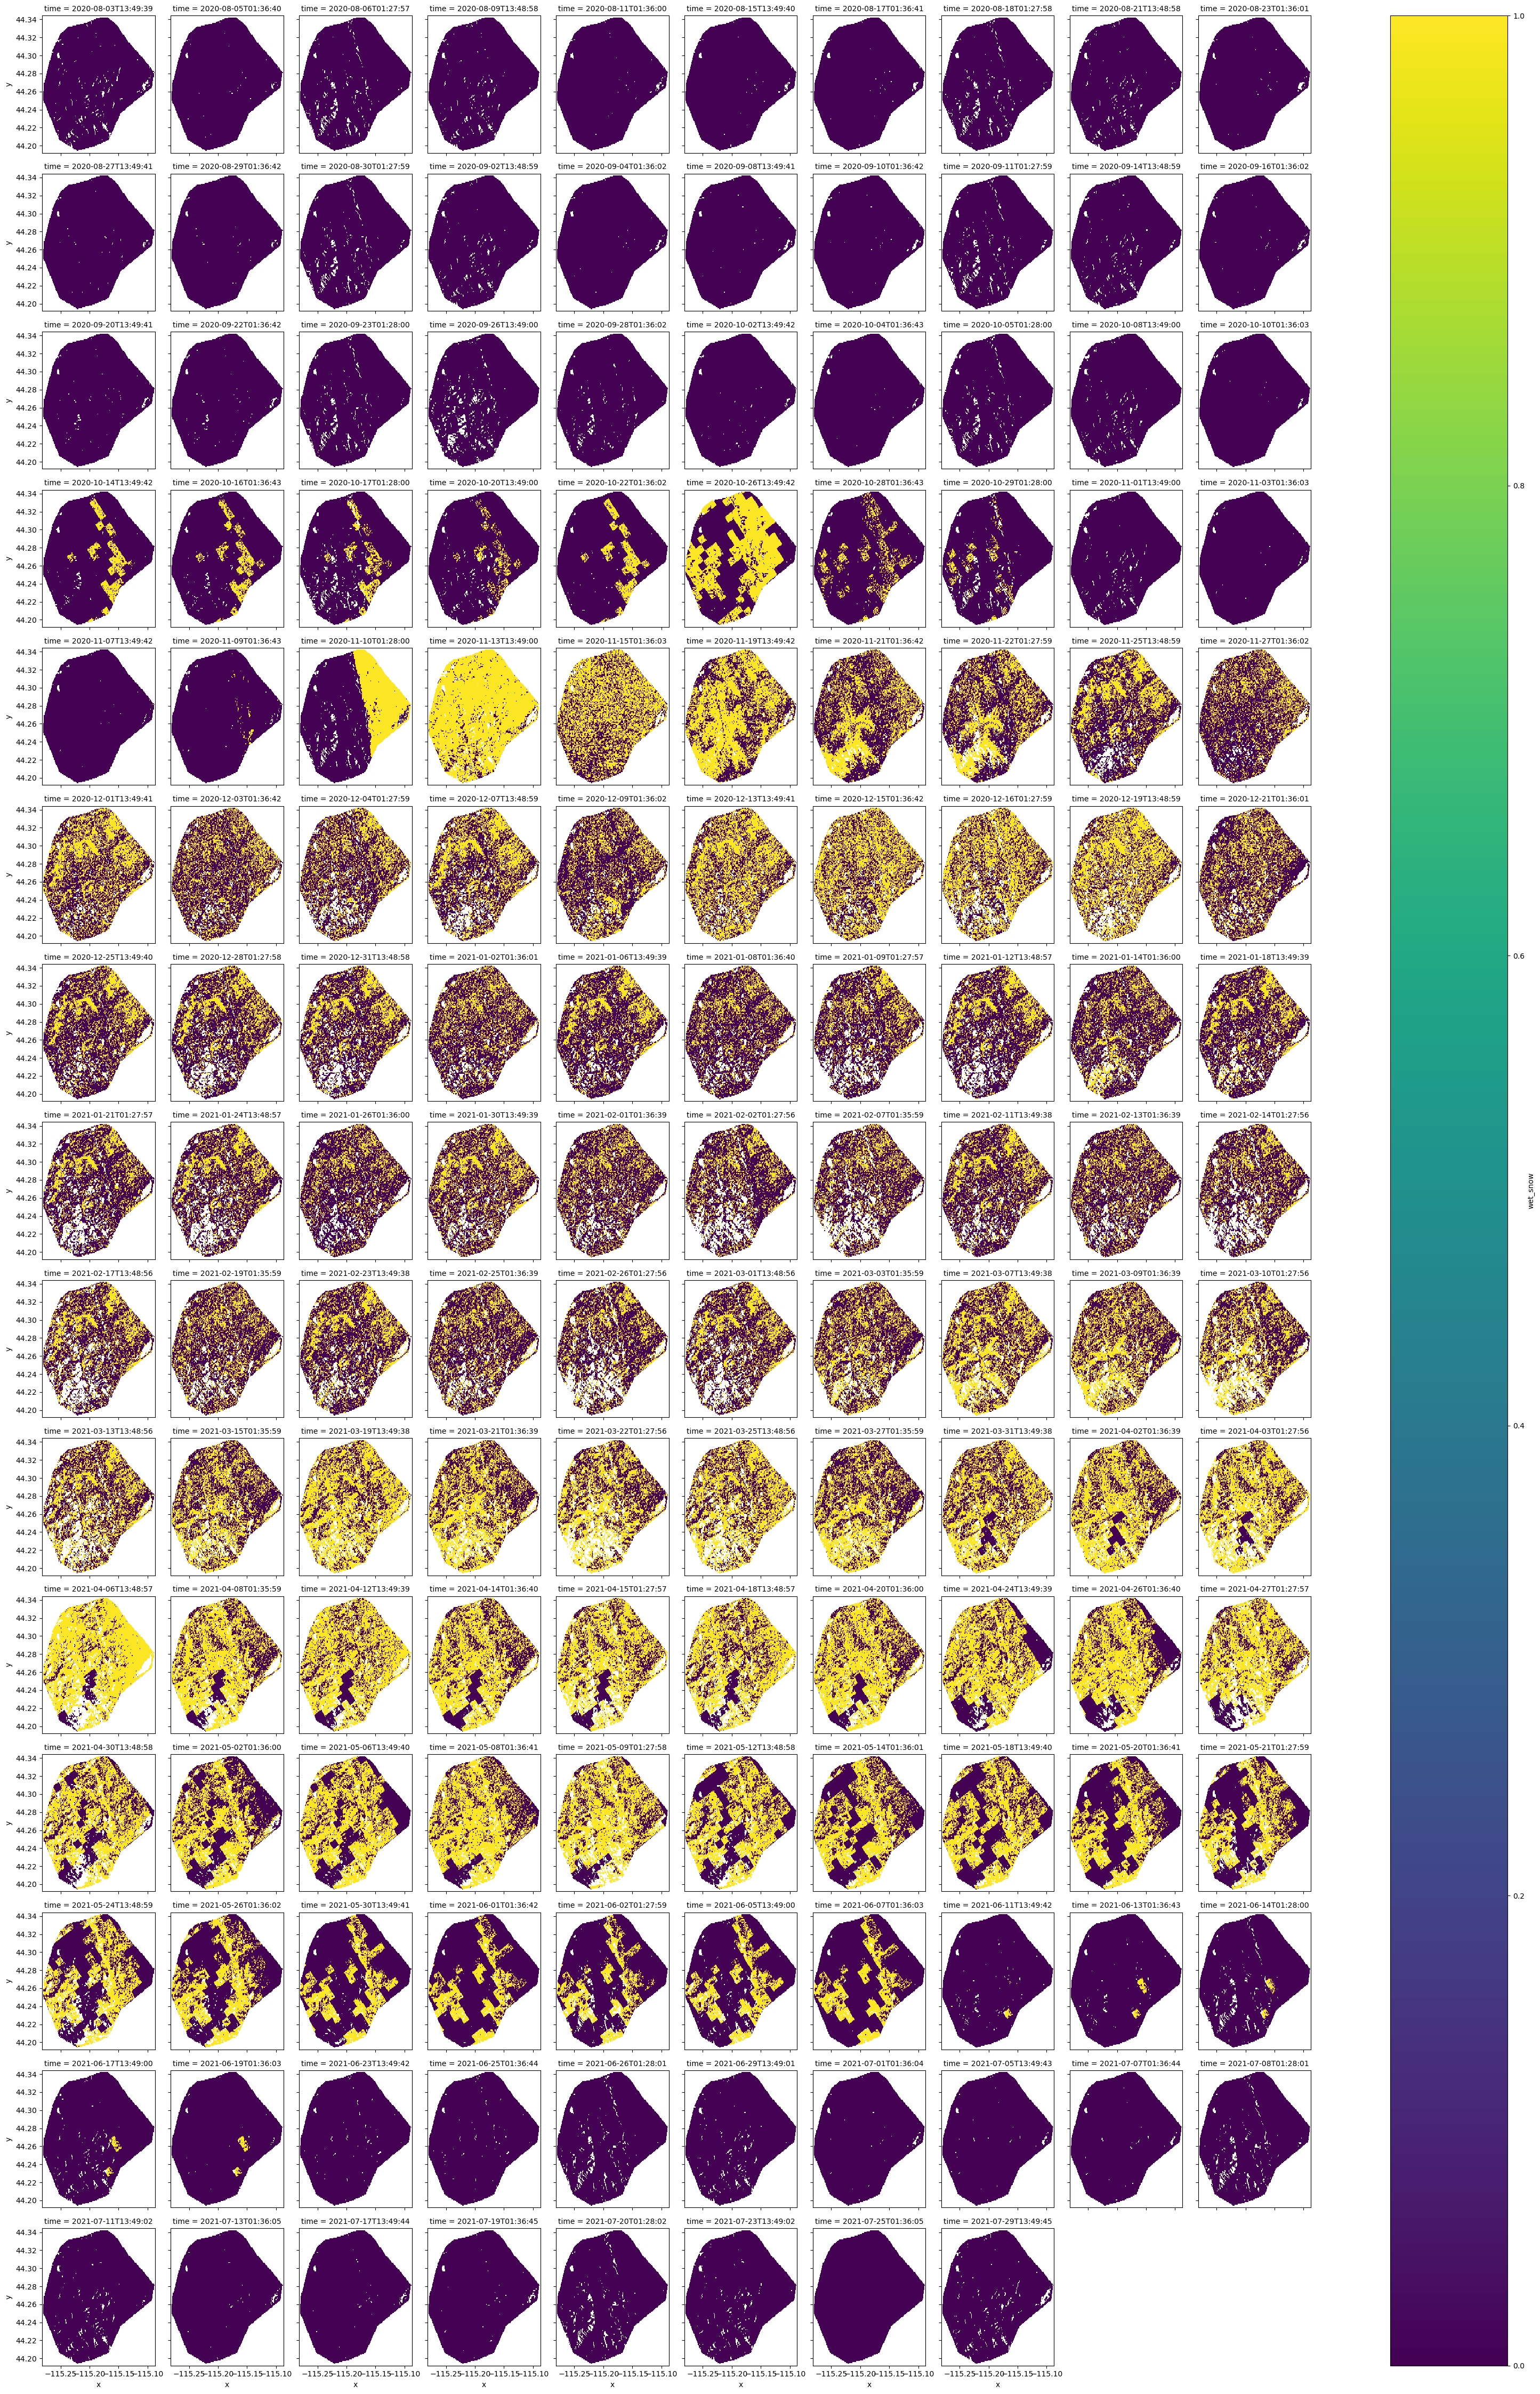

In [4]:
ds_interp = ds.interpolate_na(dim='time',method='nearest',limit=1).where(~ds['lidar-sd'].isnull())
ds_interp['wet_snow'].plot(col='time',col_wrap=10)

## Create snow map time series: 0 is no snow, 1 is wet snow, 2 is dry snow

In [5]:
all_snow = (ds_interp['ims']==4).astype(float)*2
wet_snow = ds_interp['wet_snow'].astype(float)
dry_snow = all_snow-wet_snow

ds_interp['snow_ts'] = all_snow - wet_snow 
ds_interp['snow_ts'] = ds_interp['snow_ts'].where(ds_interp['snow_ts']!=-1,0)

In [6]:
wet_cmap = ListedColormap(["white", "darkblue", "cornflowerblue"]) # colormap: no snow white, wet snow dark blue, dry snow light blue

In [7]:
# get outline of lidar area

#!pip install -q deafrica-tools 
#!pip install -q geopandas
#import geopandas as gpd
#from deafrica_tools.spatial import xr_vectorize, xr_rasterize

#clipped_area = ds_interp['snow_ts'].isel(time=-1)
#gdf = xr_vectorize(clipped_area,crs=ds.rio.crs,transform=ds.rio.transform(),mask=(clipped_area.values==1)|(clipped_area.values==2))
#boundary_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gdf.unary_union).boundary)

## Resample to weekly

In [8]:
start_date = f'{start_year}-08'
end_date = f'{start_year+1}-08'

In [9]:
num_days = 7
ds_resample = ds_interp['snow_ts'].sel(time=slice(start_date,end_date)).resample(time=f'{num_days}D').mean(dim='time')
ds_resample = ds_resample.round().rio.write_crs('EPSG:4326')
#ds_resample = ds_resample.rio.reproject(ds_resample.rio.estimate_utm_crs(),nodata=np.nan) # if we want to plot in utm

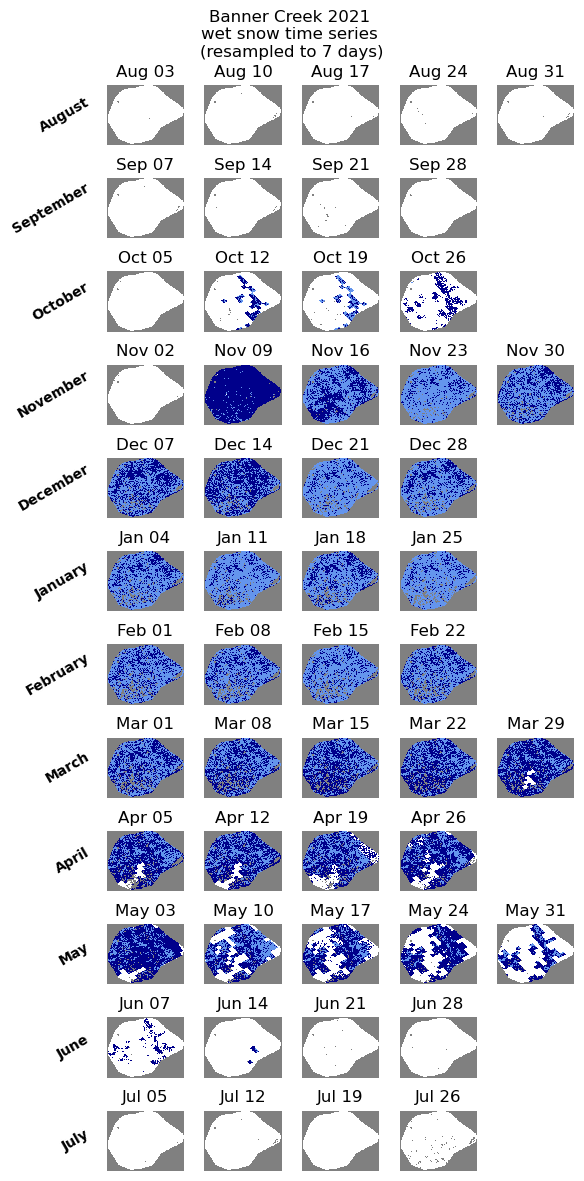

In [10]:
#plot using facet plot method
# f = ds_resample.plot(col='time',col_wrap=5, add_colorbar=False,cmap=wet_cmap) 

# for ax in f.axs.flatten():
#     ax.set_facecolor('gray')
#     #boundary_gdf.plot(ax=ax,color='black') # if we want to add outline

# f.fig.suptitle(f'Banner Creek wet snow time series \n(resampled to {num_days} days)')
# #f.fig.set_size_inches(11,7)

# f.fig.tight_layout()
# #f.fig.savefig(f'figures/banner_2021_wet_snow_ts_{num_days}days.png',dpi=600)

#p lot using subplot method, more control
f,ax=plt.subplots(12,5,figsize=(6,12),sharex=True,sharey=True)

month_index = ds_resample.time.dt.month-8
month_index = month_index.where(month_index>-1,month_index+12)
month_index = np.array(month_index)


in_each_month = np.bincount(ds_resample.time.dt.month)
so_far = np.zeros(len(in_each_month)).astype(int)



for i in range(len(ds_resample.time)):
    month = float(ds_resample.time[i].dt.month)
    month_i = month_index[i]
    ds_resample.isel(time=i).plot.imshow(ax=ax[month_i,so_far[month_i]],cmap=wet_cmap,vmin=0,vmax=2,add_colorbar=False)
    #ax[month_i,so_far[month_i]].axis('off')
    ax[month_i,so_far[month_i]].set_title(f'{pd.to_datetime(ds_resample.isel(time=i).time.values).strftime("%b %d")}')
    ax[month_i,so_far[month_i]].set_facecolor('gray')
    #ax[month_i,so_far[month_i]].set_aspect('equal')
    so_far[month_i] = so_far[month_i]+1

for axs in ax.ravel():
    #axs.axis('off')
    #axs.set_title('')
    axs.set_xlabel('')
    axs.set_ylabel('')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.get_xaxis().set_ticks([])
    axs.get_yaxis().set_ticks([])
    #axs.set_facecolor('gray')
    axs.set_aspect('equal')


rows=['August','September','October','November','December','January','February','March','April','May','June','July']
pad = 3
for axs, row in zip(ax[:,0], rows):
    axs.annotate(row,xy=(0, 0.5), xytext=(-axs.yaxis.labelpad-pad,0),                    
                xycoords=axs.yaxis.label, textcoords='offset points',
                size=10, ha='right', va='center',rotation=30, weight='bold')

f.suptitle(f'Banner Creek 2021 \nwet snow time series \n(resampled to {num_days} days)')
f.tight_layout()

f.savefig(f'figures/banner_2021_wet_snow_ts_{num_days}days.png',dpi=600)

## Bring in some SNOTEL data and compare with number of wet pixels over time

In [12]:
code = '312_ID_SNTL'
snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{code}.parquet').loc[slice(start_date,end_date)]
snotel_TAVG = snotel_data['TAVG']
snotel_SNWD = snotel_data['SNWD']

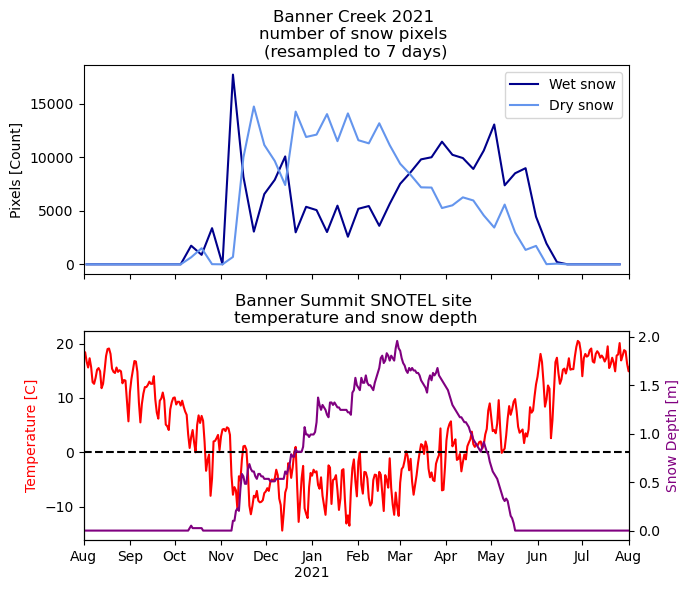

In [14]:
f,ax=plt.subplots(2,1,figsize=(7,6),sharex=True)
PRCP_ax = ax[1].twinx()

wet_snow_ts = (ds_resample==1).sum(dim=['x','y'])
dry_snow_ts = (ds_resample==2).sum(dim=['x','y'])
total_ts = wet_snow_ts + dry_snow_ts
wet_snow_ts.plot(ax=ax[0],color='darkblue')
dry_snow_ts.plot(ax=ax[0],color='cornflowerblue')

snotel_TAVG.plot(ax=ax[1], color='red')
snotel_SNWD.plot(ax=PRCP_ax,color='purple')

ax[1].axhline(0,color='black',linestyle='--')

ax[0].set_xlim([pd.to_datetime(start_date),pd.to_datetime(end_date)])
ax[1].set_xlim([pd.to_datetime(start_date),pd.to_datetime(end_date)])

ax[0].minorticks_off()
ax[1].minorticks_off()

ax[0].set_title(f'Banner Creek 2021 \nnumber of snow pixels \n(resampled to {num_days} days)')
ax[0].set_ylabel('Pixels [Count]')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[1].set_title('Banner Summit SNOTEL site \ntemperature and snow depth')
ax[1].set_ylabel('Temperature [C]')
PRCP_ax.set_xlabel('')
PRCP_ax.set_ylabel('Snow Depth [m]')

ax[1].yaxis.label.set_color('red')
PRCP_ax.yaxis.label.set_color('purple')

ax[0].legend(['Wet snow','Dry snow'])

plt.tight_layout()

f.savefig(f'figures/banner_2021_wet_snow_and_snotel_{num_days}days.png',dpi=600)